# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [70]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 17 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_ngill_2b13bj
H2O cluster total nodes:,1
H2O cluster free memory:,9.62 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [71]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [72]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (160338, 23)
Test shape: (39662, 22)


In [73]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1
4.00076e+06,265000,95,1,0,285000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5
5.45314e+06,275000,57.9,1,0,475000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5
1.94229e+06,595000,80,1,0,745000,371,0,nan,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4


In [74]:
train.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
type,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,49.0,5000.0,1.0,0.0,0.0,5000.0,-130.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,3319386.4112125635,291981.00263194024,86.64662923818423,0.9436378151155683,5.35342838254188,358807.76858885604,152.333788621537,0.09670196709451284,42.51917601153023,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353814,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.0030373336327
maxs,6504996.0,12005000.0,900.0,1.0,425.0,13605000.0,882000.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
sigma,1952820.8522752034,227416.2209992358,15.01109708563018,0.2306205123360138,24.864561487883368,324310.1569850146,2886.174831533794,0.295552434347859,3.973609138536163,0.1951890799460008,0.25844393424533546,0.26936092454879995,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.48715526363003847,0.41175035739904686,0.41175035739904686,1.4115197617501203
zeros,0,0,0,9037,151301,0,982,144833,0,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0
missing,0,0,0,0,0,0,0,0,74997,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0
0,2549300.0,175000.0,97.0,1.0,0.0,185000.0,36.0,0.0,47.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0
1,4000757.0,265000.0,95.0,1.0,0.0,285000.0,100.0,0.0,nan,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0
2,1546928.0,115000.0,97.0,0.0,120.0,125000.0,59.0,0.0,39.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0


In [75]:
print(f"Min for train loan_to_value_ratio: {train['loan_to_value_ratio'].min()}")
print(f"Max for train loan_to_value_ratio: {train['loan_to_value_ratio'].max()}")

Min for train loan_to_value_ratio: 1.0
Max for train loan_to_value_ratio: 900.0


In [76]:
ltv_train = train['loan_to_value_ratio'].as_data_frame().values

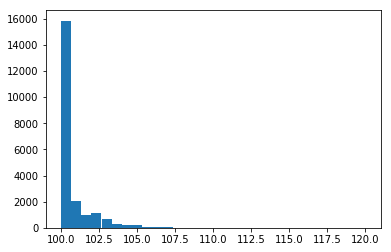

In [77]:
plt.hist(ltv_train, bins=30, range=(100,120))
plt.show()

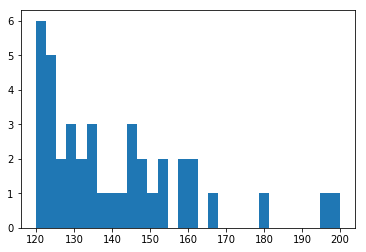

In [78]:
plt.hist(ltv_train, bins=30, range=(120,200))
plt.show()

In [79]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
131497,185000,96.5,1,0,195000,129,0,nan,1,1,0,1,0,0,0,1,0,1,0,nan,nan
851117,365000,95,0,85,385000,121,0,nan,1,1,0,1,0,0,0,0,1,1,0,nan,nan
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1
843194,365000,96.5,1,0,375000,51,1,nan,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1
6.37726e+06,195000,96.5,1,0,205000,54,0,nan,1,1,0,0,1,0,0,0,1,0,1,nan,nan
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0


In [80]:
test.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
type,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,4056.0,5000.0,1.0,0.0,0.0,25000.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3323235.64242852,292912.61156774743,88.56029290647881,0.9412283798093893,5.4916040542584845,360743.028591599,182.90381221320155,0.09752407846301246,42.49417061611374,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092
maxs,6504997.0,4625000.0,79474.0,1.0,360.0,9245000.0,396000.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,1954622.3871122967,224087.83385259155,398.9005406950038,0.23519972706038758,24.4766458606141,321800.26166856906,3600.669509692802,0.29667381367158185,3.9708418924862814,0.19551834219733183,0.2614461483363615,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798
zeros,0,0,0,2331,37331,0,231,35794,0,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431
missing,0,0,0,0,0,0,0,0,18562,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582
0,131497.0,185000.0,96.5,1.0,0.0,195000.0,129.0,0.0,nan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan
1,851117.0,365000.0,95.0,0.0,85.0,385000.0,121.0,0.0,nan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan
2,835616.0,265000.0,96.28,1.0,0.0,265000.0,106.0,0.0,49.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0


In [81]:
print(f"Min for test loan_to_value_ratio: {test['loan_to_value_ratio'].min()}")
print(f"Max for test loan_to_value_ratio: {test['loan_to_value_ratio'].max()}")

Min for test loan_to_value_ratio: 1.0
Max for test loan_to_value_ratio: 79474.0


In [82]:
ltv_test = test['loan_to_value_ratio'].as_data_frame().values

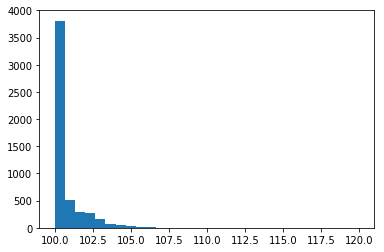

In [83]:
plt.hist(ltv_test, bins=30, range=(100,120))
plt.show()

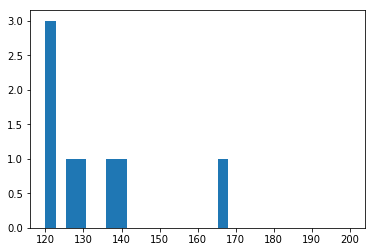

In [84]:
plt.hist(ltv_test, bins=30, range=(120,200))
plt.show()

In [85]:
# Feature Engineering

# Train
train['loan_amount_conforming'] = (train["conforming"] == 1).ifelse(train['loan_amount'], np.nan)
train['loan_amount_non_conforming'] = (train["conforming"] == 0).ifelse(train['loan_amount'], np.nan)
train['loan_to_value_ratio_manual'] = train['loan_amount'] / train['property_value'] * 100
train['loan_to_value_ratio_manual'] = train['loan_to_value_ratio_manual'].round()

#Test
test['loan_amount_conforming'] = (test["conforming"] == 1).ifelse(test['loan_amount'], np.nan)
test['loan_amount_non_conforming'] = (test["conforming"] == 0).ifelse(test['loan_amount'], np.nan)
test['loan_to_value_ratio_manual'] = test['loan_amount'] / test['property_value'] * 100
test['loan_to_value_ratio_manual'] = test['loan_to_value_ratio_manual'].round()

In [86]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1,175000,nan,95
4.00076e+06,265000,95,1,0,285000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5,265000,nan,93
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5,115000,nan,92
5.45314e+06,275000,57.9,1,0,475000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,275000,nan,58
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4,155000,nan,100
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,215000,nan,96
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1,195000,nan,95
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2,125000,nan,100
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5,355000,nan,90
1.94229e+06,595000,80,1,0,745000,371,0,nan,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4,nan,595000,80


In [87]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual
131497,185000,96.5,1,0,195000,129,0,nan,1,1,0,1,0,0,0,1,0,1,0,nan,nan,185000,nan,95
851117,365000,95,0,85,385000,121,0,nan,1,1,0,1,0,0,0,0,1,1,0,nan,nan,365000,nan,95
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1,265000,nan,100
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0,145000,nan,57
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1,355000,nan,95
843194,365000,96.5,1,0,375000,51,1,nan,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1,365000,nan,97
6.37726e+06,195000,96.5,1,0,205000,54,0,nan,1,1,0,0,1,0,0,0,1,0,1,nan,nan,195000,nan,95
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan,135000,nan,82
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan,455000,nan,69
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0,325000,nan,80


In [88]:
# Inputs and output
X = ['loan_amount_conforming', 'loan_amount_non_conforming', 'loan_to_value_ratio_manual', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', "debt_to_income_ratio", "term_360", "conforming"]
fold_column = 'cv_fold'
Y = "high_priced"

In [89]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [90]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [91]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [92]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [93]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [94]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount_conforming,-0.139775
loan_amount_non_conforming,-0.005549
loan_to_value_ratio_manual,0.111645
no_intro_rate_period,0.018108
intro_rate_period,-0.031716
property_value,-0.137319
income,-0.007911
debt_to_income_ratio,0.031007
term_360,0.052448
conforming,0.074543


In [95]:
# Filter to correlations > 0.1
numeric_corr = numeric_corr[numeric_corr['high_priced'].abs() > 0.1]
numeric_corr

,high_priced
loan_amount_conforming,-0.139775
loan_to_value_ratio_manual,0.111645
property_value,-0.137319


In [96]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[list(numeric_corr.index) + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
#del mono_constraints['loan_amount_conforming']
#del mono_constraints['property_value']
mono_constraints

{'loan_amount_conforming': -1,
 'loan_to_value_ratio_manual': 1,
 'property_value': -1}

In [29]:
# Default GBM with monotonic constraints
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575477968799_53312


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,16070.0,5.0,5.0,5.0,14.0,29.0,20.98




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07933489572265526
RMSE: 0.28166450916410335
LogLoss: 0.2675153535439777
Mean Per-Class Error: 0.2646148704179936
AUC: 0.7886934869285664
pr_auc: 0.23662763841349788
Gini: 0.5773869738571329

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1317844861338725: 


,,0,1,Error,Rate
0,0,102068.0,42765.0,0.2953,(42765.0/144833.0)
1,1,4120.0,11385.0,0.2657,(4120.0/15505.0)
2,Total,106188.0,54150.0,0.2924,(46885.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.131784,0.326897,233.0
1,max f2,0.103632,0.507135,260.0
2,max f0point5,0.203468,0.264825,163.0
3,max accuracy,0.912300,0.903304,0.0
4,max precision,0.912300,1.000000,0.0
5,max recall,0.005145,1.000000,398.0
6,max specificity,0.912300,1.000000,0.0
7,max absolute_mcc,0.114555,0.284757,250.0
8,max min_per_class_accuracy,0.135207,0.712480,230.0
9,max mean_per_class_accuracy,0.103632,0.735385,260.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.64 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010079,0.381414,3.762709,3.762709,0.363861,0.447555,0.363861,0.447555,0.037923,0.037923,276.270925,276.270925
1,,2,0.020270,0.331774,2.847903,3.302773,0.275398,0.357397,0.319385,0.402226,0.029023,0.066946,184.790274,230.277268
2,,3,0.030405,0.280762,2.870039,3.158528,0.277538,0.301821,0.305436,0.368758,0.029087,0.096034,187.003946,215.852828
3,,4,0.040134,0.271630,2.870305,3.088656,0.277564,0.274239,0.298679,0.345844,0.027926,0.123960,187.030462,208.865587
4,,5,0.050506,0.264451,2.344303,2.935796,0.226699,0.268299,0.283897,0.329920,0.024315,0.148275,134.430327,193.579611
5,,6,0.100064,0.216721,2.454471,2.697413,0.237352,0.233038,0.260845,0.281938,0.121638,0.269913,145.447051,169.741334
6,,7,0.150008,0.195813,2.151373,2.515612,0.208042,0.206217,0.243265,0.256727,0.107449,0.377362,115.137256,151.561163
7,,8,0.200950,0.180274,2.094038,2.408740,0.202498,0.189086,0.232930,0.239579,0.106675,0.484037,109.403756,140.873960
8,,9,0.300228,0.151061,1.865781,2.229197,0.180425,0.165497,0.215568,0.215082,0.185231,0.669268,86.578083,122.919708
9,,10,0.400878,0.102702,1.553272,2.059490,0.150204,0.126312,0.199157,0.192794,0.156337,0.825605,55.327229,105.949028




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07956778709635609
RMSE: 0.2820776260116284
LogLoss: 0.26847602147336325
Mean Per-Class Error: 0.26594634219082014
AUC: 0.7861514819680244
pr_auc: 0.23214484281507994
Gini: 0.5723029639360488

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15663648331095548: 


,,0,1,Error,Rate
0,0,109158.0,35675.0,0.2463,(35675.0/144833.0)
1,1,5580.0,9925.0,0.3599,(5580.0/15505.0)
2,Total,114738.0,45600.0,0.2573,(41255.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.156636,0.324851,216.0
1,max f2,0.102472,0.505593,268.0
2,max f0point5,0.206574,0.262780,159.0
3,max accuracy,0.908485,0.903292,0.0
4,max precision,0.423219,0.347032,51.0
5,max recall,0.004181,1.000000,399.0
6,max specificity,0.908485,0.999993,0.0
7,max absolute_mcc,0.106352,0.282533,264.0
8,max min_per_class_accuracy,0.135434,0.711454,237.0
9,max mean_per_class_accuracy,0.102472,0.734054,268.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.65 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.382481,3.507189,3.507189,0.339152,0.447889,0.339152,0.447889,0.035085,0.035085,250.718946,250.718946
1,,2,0.020058,0.334571,3.034316,3.270165,0.293424,0.355646,0.316231,0.401653,0.030506,0.065592,203.431591,227.016454
2,,3,0.030080,0.282852,2.702702,3.081089,0.261357,0.302567,0.297947,0.368638,0.027088,0.092680,170.270164,208.108868
3,,4,0.040015,0.270867,2.706980,2.988203,0.261770,0.276170,0.288965,0.345679,0.026895,0.119574,170.697952,198.820278
4,,5,0.050069,0.261266,2.495452,2.889260,0.241315,0.266277,0.279397,0.329736,0.025089,0.144663,149.545220,188.925984
5,,6,0.100014,0.216293,2.413515,2.651684,0.233392,0.233362,0.256423,0.281609,0.120542,0.265205,141.351459,165.168389
6,,7,0.150033,0.197029,2.175231,2.492840,0.210349,0.206026,0.241063,0.256410,0.108804,0.374008,117.523111,149.283989
7,,8,0.200002,0.178558,2.090926,2.392424,0.202197,0.189517,0.231352,0.239698,0.104482,0.478491,109.092649,139.242420
8,,9,0.300016,0.148873,1.872687,2.219164,0.181093,0.164624,0.214598,0.214671,0.187294,0.665785,87.268726,121.916415
9,,10,0.400111,0.103609,1.563175,2.055057,0.151162,0.126916,0.198728,0.192717,0.156466,0.822251,56.317468,105.505686




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.70970845,0.02868148,0.7226218,0.72432435,0.74258876,0.68098027,0.67802715
1,auc,0.7863498,0.0041343505,0.782654,0.79284585,0.784634,0.7879266,0.78368837
2,err,0.29029155,0.02868148,0.2773782,0.27567568,0.2574112,0.31901973,0.32197288
3,err_count,9312.2,963.4416,8870.0,8772.0,8249.0,10297.0,10373.0
4,f0point5,0.2456381,0.007953654,0.24452995,0.25765008,0.24780752,0.23615476,0.24204822
5,f1,0.3262368,0.0069908686,0.3223835,0.3378623,0.3222414,0.3210023,0.3276946
6,f2,0.48646024,0.019415956,0.4729669,0.49059582,0.46058813,0.5010086,0.5071417
7,lift_top_group,3.538813,0.18310314,3.7537308,3.5054636,3.698832,3.4058247,3.3302147
8,logloss,0.26848513,0.0038956045,0.26892483,0.2723038,0.2657638,0.26339573,0.27203754
9,max_per_class_error,0.32643723,0.021785803,0.31315103,0.2977722,0.35472193,0.33141783,0.33512324



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-04 11:53:06,17.918 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-04 11:53:06,17.963 sec,1.0,0.293249,0.310209,0.765908,0.220467,3.471004,0.267591
2,,2019-12-04 11:53:06,18.001 sec,2.0,0.291473,0.304621,0.768227,0.222191,3.471004,0.287331
3,,2019-12-04 11:53:06,18.044 sec,3.0,0.290073,0.300285,0.767200,0.221973,3.471004,0.296792
4,,2019-12-04 11:53:06,18.084 sec,4.0,0.288933,0.296752,0.766562,0.227454,3.471004,0.299012
5,,2019-12-04 11:53:06,18.122 sec,5.0,0.287907,0.293476,0.769959,0.228477,3.853808,0.261678
6,,2019-12-04 11:53:06,18.163 sec,6.0,0.287130,0.291014,0.769236,0.229251,3.835176,0.260387
7,,2019-12-04 11:53:06,18.209 sec,7.0,0.286471,0.288884,0.769056,0.229663,3.851547,0.259945
8,,2019-12-04 11:53:06,18.256 sec,8.0,0.285881,0.286868,0.770439,0.229818,3.858032,0.278399
9,,2019-12-04 11:53:06,18.306 sec,9.0,0.285445,0.285434,0.770102,0.230390,3.858032,0.278424



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,3846.603760,1.000000,0.534172
1,property_value,1599.517212,0.415826,0.222122
2,loan_amount_conforming,625.621033,0.162642,0.086879
3,intro_rate_period,564.312805,0.146704,0.078365
4,debt_to_income_ratio,271.226440,0.070511,0.037665
5,no_intro_rate_period,128.446671,0.033392,0.017837
6,term_360,79.788864,0.020743,0.011080
7,income,45.824688,0.011913,0.006364
8,loan_amount_non_conforming,39.456882,0.010258,0.005479
9,conforming,0.266125,0.000069,0.000037


In [31]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.7891909843578667


In [32]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.7861514819680244


In [33]:
# Default GBM
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [34]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575477968799_53651


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21794.0,5.0,5.0,5.0,20.0,32.0,30.1




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07689638117853816
RMSE: 0.2773019674984982
LogLoss: 0.25699573878765214
Mean Per-Class Error: 0.2414819440445608
AUC: 0.8110950613620576
pr_auc: 0.2796347277833918
Gini: 0.6221901227241151

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1630041660890534: 


,,0,1,Error,Rate
0,0,103147.0,41686.0,0.2878,(41686.0/144833.0)
1,1,3360.0,12145.0,0.2167,(3360.0/15505.0)
2,Total,106507.0,53831.0,0.2809,(45046.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.163004,0.350323,212.0
1,max f2,0.114953,0.533561,249.0
2,max f0point5,0.217992,0.286977,148.0
3,max accuracy,0.403734,0.904221,46.0
4,max precision,0.745048,1.000000,0.0
5,max recall,0.005002,1.000000,399.0
6,max specificity,0.745048,1.000000,0.0
7,max absolute_mcc,0.151297,0.314563,226.0
8,max min_per_class_accuracy,0.171104,0.733300,203.0
9,max mean_per_class_accuracy,0.085488,0.758518,268.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010160,0.322036,5.059434,5.059434,0.489257,0.399057,0.489257,0.399057,0.051403,0.051403,405.943393,405.943393
1,,2,0.020001,0.288919,2.994842,4.043554,0.289607,0.305252,0.391020,0.352900,0.029474,0.080877,199.484185,304.355419
2,,3,0.030698,0.269146,3.105330,3.716644,0.300292,0.274683,0.359407,0.325647,0.033215,0.114092,210.533027,271.664358
3,,4,0.043034,0.263670,2.959067,3.499472,0.286148,0.265437,0.338406,0.308387,0.036504,0.150597,195.906725,249.947170
4,,5,0.050238,0.259898,2.882960,3.411071,0.278788,0.262171,0.329857,0.301760,0.020767,0.171364,188.295975,241.107054
5,,6,0.100326,0.230136,2.446519,2.929515,0.236583,0.247221,0.283290,0.274531,0.122541,0.293905,144.651941,192.951453
6,,7,0.150201,0.211659,2.406489,2.755839,0.232712,0.218353,0.266495,0.255876,0.120026,0.413931,140.648949,175.583885
7,,8,0.200015,0.199215,2.149261,2.604771,0.207838,0.205128,0.251886,0.243238,0.107062,0.520993,114.926069,160.477119
8,,9,0.301931,0.175268,1.954807,2.385378,0.189034,0.187505,0.230671,0.224425,0.199226,0.720219,95.480738,138.537769
9,,10,0.400173,0.086282,1.494831,2.166749,0.144553,0.148158,0.209529,0.205702,0.146856,0.867075,49.483074,116.674865




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07745978526982422
RMSE: 0.27831598098173277
LogLoss: 0.25934018840422635
Mean Per-Class Error: 0.24426963311521865
AUC: 0.8055607252746407
pr_auc: 0.263521427249809
Gini: 0.6111214505492815

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16363699661348421: 


,,0,1,Error,Rate
0,0,103524.0,41309.0,0.2852,(41309.0/144833.0)
1,1,3583.0,11922.0,0.2311,(3583.0/15505.0)
2,Total,107107.0,53231.0,0.28,(44892.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.163637,0.346892,222.0
1,max f2,0.099415,0.530012,267.0
2,max f0point5,0.216742,0.282338,157.0
3,max accuracy,0.476683,0.903691,28.0
4,max precision,0.612326,0.775000,10.0
5,max recall,0.005070,1.000000,399.0
6,max specificity,0.821368,0.999993,0.0
7,max absolute_mcc,0.137712,0.310398,245.0
8,max min_per_class_accuracy,0.169763,0.731429,215.0
9,max mean_per_class_accuracy,0.093256,0.755730,271.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010023,0.327798,4.453023,4.453023,0.430616,0.395963,0.430616,0.395963,0.044631,0.044631,345.302270,345.302270
1,,2,0.020001,0.291474,3.037684,3.746898,0.293750,0.307724,0.362332,0.351940,0.030313,0.074944,203.768381,274.689790
2,,3,0.030005,0.274175,2.984979,3.492872,0.288653,0.281360,0.337768,0.328408,0.029861,0.104805,198.497926,249.287223
3,,4,0.040028,0.265461,2.934362,3.353027,0.283759,0.269409,0.324244,0.313636,0.029410,0.134215,193.436178,235.302706
4,,5,0.050032,0.260039,2.798015,3.242052,0.270574,0.262458,0.313513,0.303403,0.027991,0.162206,179.801512,224.205235
5,,6,0.100001,0.228975,2.491042,2.866781,0.240889,0.245662,0.277223,0.274550,0.124476,0.286682,149.104206,186.678140
6,,7,0.150077,0.210306,2.293861,2.675618,0.221821,0.217472,0.258737,0.255505,0.114866,0.401548,129.386129,167.561756
7,,8,0.200052,0.199705,2.124219,2.537871,0.205416,0.205522,0.245417,0.243019,0.106159,0.507707,112.421944,153.787117
8,,9,0.300004,0.174194,2.005490,2.360499,0.193935,0.186636,0.228265,0.224234,0.200451,0.708159,100.549029,136.049942
9,,10,0.399999,0.089253,1.536355,2.154473,0.148569,0.147798,0.208342,0.205126,0.153628,0.861787,53.635528,115.447302




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.72492146,0.008039739,0.73366064,0.73350096,0.71693814,0.71945965,0.7210479
1,auc,0.8057819,0.0036937087,0.8056663,0.81034654,0.80145097,0.8084579,0.8029879
2,err,0.27507854,0.008039739,0.26633936,0.26649904,0.28306186,0.28054032,0.2789521
3,err_count,8822.0,297.281,8517.0,8480.0,9071.0,9055.0,8987.0
4,f0point5,0.26229447,0.008231489,0.26286954,0.2747809,0.25335434,0.2566027,0.26386493
5,f1,0.34734792,0.008489906,0.34620404,0.3603862,0.33793154,0.34255427,0.3496635
6,f2,0.514175,0.007131811,0.506901,0.5234673,0.507275,0.515088,0.5181436
7,lift_top_group,4.4534345,0.20348565,4.590527,4.3818293,4.1262717,4.598958,4.5695863
8,logloss,0.25935048,0.0042328034,0.25871447,0.2636432,0.2578245,0.2533741,0.26319608
9,max_per_class_error,0.27847204,0.010299573,0.26638067,0.26829183,0.28775814,0.2863691,0.2835605



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-04 11:53:27,16.054 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-04 11:53:27,16.092 sec,1.0,0.292622,0.308192,0.788840,0.237923,3.627060,0.340830
2,,2019-12-04 11:53:27,16.125 sec,2.0,0.290220,0.300664,0.792112,0.241397,3.704893,0.274059
3,,2019-12-04 11:53:27,16.158 sec,3.0,0.288302,0.294728,0.793310,0.242219,3.704893,0.279653
4,,2019-12-04 11:53:28,16.192 sec,4.0,0.286706,0.289799,0.795029,0.248804,4.316959,0.275300
5,,2019-12-04 11:53:28,16.229 sec,5.0,0.285328,0.285527,0.797335,0.250123,4.316959,0.321458
6,,2019-12-04 11:53:28,16.264 sec,6.0,0.284245,0.282066,0.797461,0.251245,4.301406,0.322151
7,,2019-12-04 11:53:28,16.299 sec,7.0,0.283308,0.279044,0.798258,0.252550,4.254375,0.320598
8,,2019-12-04 11:53:28,16.337 sec,8.0,0.282535,0.276485,0.798883,0.253567,4.290624,0.271470
9,,2019-12-04 11:53:28,16.416 sec,9.0,0.281925,0.274399,0.800154,0.254687,4.271304,0.279971



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,4902.114746,1.000000,0.576878
1,property_value,1852.255127,0.377848,0.217972
2,intro_rate_period,634.687378,0.129472,0.074690
3,loan_amount_conforming,415.683838,0.084797,0.048917
4,debt_to_income_ratio,295.166199,0.060212,0.034735
5,no_intro_rate_period,176.666489,0.036039,0.020790
6,income,140.363678,0.028633,0.016518
7,term_360,68.090675,0.013890,0.008013
8,loan_amount_non_conforming,12.627782,0.002576,0.001486
9,conforming,0.000000,0.000000,0.000000


In [35]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.8085086439703604


In [36]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8055607252746407


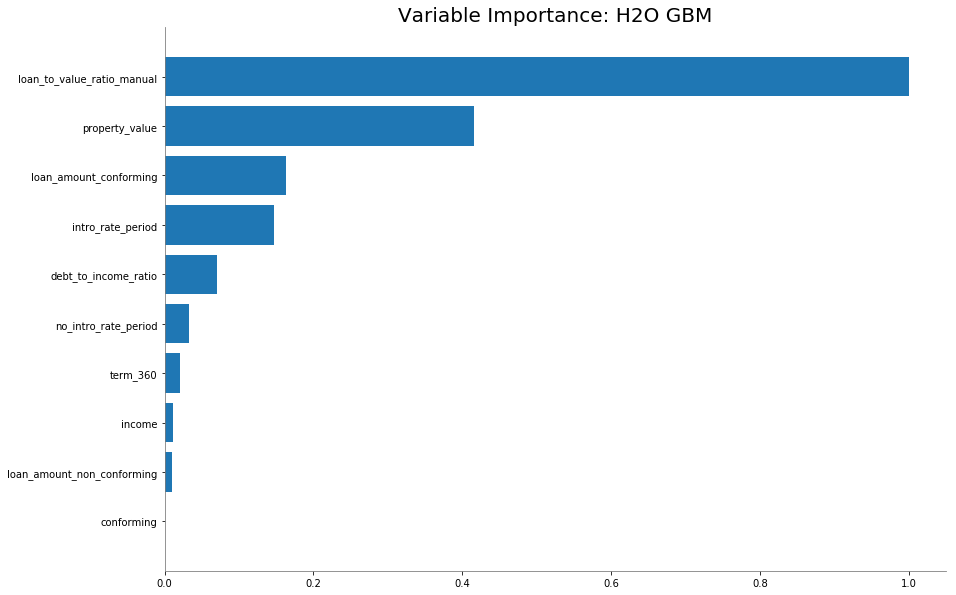

In [39]:
# MGBM var importance
mgbm_default.varimp_plot()

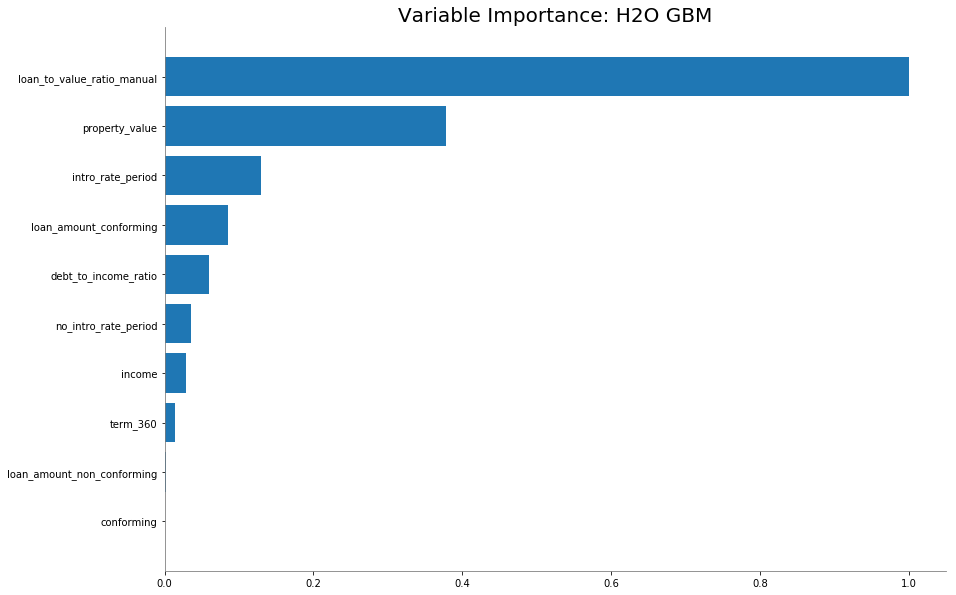

In [40]:
# GBM var importance
gbm_default.varimp_plot()

## Shapley for MGBM

In [41]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
0.00273055,0.00162731,0.355012,-0.0260076,0.219431,0.0216907,0.000346161,0.0622099,0.00916304,1.10211,-2.83589
-0.00416844,0.00638539,-0.0849295,0.0064411,-0.0772205,0.0290891,8.83e-05,-0.0588667,0.0162718,0.605376,-2.83589
-0.118003,-0.762378,0.568668,-0.0410394,-0.0323592,0.016615,0.000179928,0.115807,0.0170214,0.542727,-2.83589
-0.0152649,-0.00538399,-0.370521,0.00437946,-0.0669006,0.0333133,0.000109837,-0.0453622,0.0343331,-1.21962,-2.83589
0.00392473,0.00207079,0.433767,-0.024102,0.188586,0.0216765,0.000346161,0.0750041,0.0103233,1.09495,-2.83589


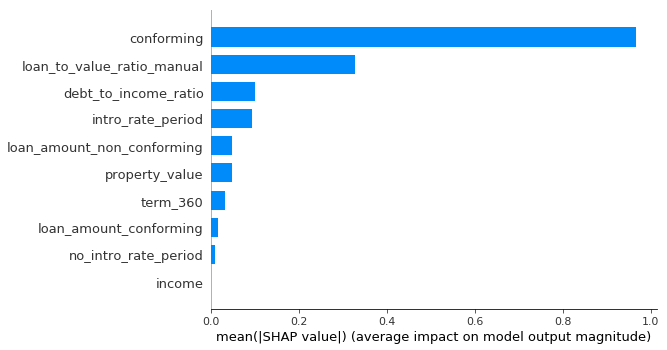

In [42]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [43]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.00845032,0.00840667,0.394041,-0.0275127,0.16803,0.0222382,0,0.097104,-0.00148163,1.22723,-2.9804
-0.0177023,0.00840181,-0.273557,0.000542701,-0.143093,0.0234107,0,0.0316126,0.000327969,0.498437,-2.9804
-0.357596,-0.432481,0.757311,-0.0115536,0.143213,0.00995941,0,0.0999021,-0.000213555,0.512092,-2.9804
-0.124687,-0.00430281,-0.500944,-0.00155896,-0.0577928,0.0176678,0,0.0259578,-0.00168392,-1.24789,-2.9804
-0.00757725,0.0122064,0.37853,0.00660085,0.171597,0.0190618,0,0.137587,-0.00048845,1.193,-2.9804


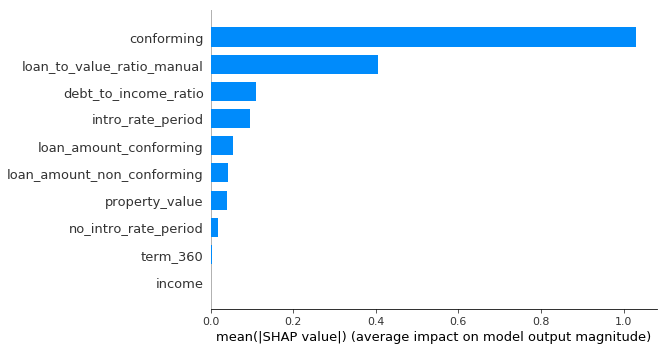

In [44]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

In [45]:
# Default XGBoost with monotonic constraints
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [46]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575477968799_54054


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07738202724563056
RMSE: 0.27817625212377595
LogLoss: 0.2584014315941231
Mean Per-Class Error: 0.2497653135554383
AUC: 0.808232515981171
pr_auc: 0.2716380222199313
Gini: 0.6164650319623419

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1659909658441224: 


,,0,1,Error,Rate
0,0,110278.0,34555.0,0.2386,(34555.0/144833.0)
1,1,5086.0,10419.0,0.328,(5086.0/15505.0)
2,Total,115364.0,44974.0,0.2472,(39641.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.165991,0.344549,220.0
1,max f2,0.094574,0.522949,280.0
2,max f0point5,0.222719,0.291028,160.0
3,max accuracy,0.543491,0.903672,33.0
4,max precision,0.942579,1.000000,0.0
5,max recall,0.000872,1.000000,398.0
6,max specificity,0.942579,1.000000,0.0
7,max absolute_mcc,0.117294,0.300800,261.0
8,max min_per_class_accuracy,0.154174,0.729744,232.0
9,max mean_per_class_accuracy,0.093815,0.750235,281.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010016,0.387084,4.809941,4.809941,0.465131,0.473297,0.465131,0.473297,0.048178,0.048178,380.994103,380.994103
1,,2,0.020026,0.335247,3.337486,4.073943,0.322741,0.353144,0.393958,0.413239,0.033409,0.081587,233.748571,307.394265
2,,3,0.030099,0.307928,3.028679,3.724150,0.292879,0.318886,0.360133,0.381664,0.030506,0.112093,202.867941,272.414984
3,,4,0.040022,0.289276,3.106865,3.571103,0.300440,0.298501,0.345333,0.361045,0.030829,0.142922,210.686518,257.110326
4,,5,0.050250,0.273338,2.887928,3.432043,0.279268,0.280765,0.331885,0.344704,0.029539,0.172460,188.792773,243.204308
5,,6,0.100138,0.225461,2.513190,2.974276,0.243030,0.245985,0.287618,0.295523,0.125379,0.297839,151.318961,197.427596
6,,7,0.150083,0.203338,2.294711,2.748131,0.221903,0.212429,0.265750,0.267871,0.114608,0.412448,129.471130,174.813094
7,,8,0.200165,0.190588,2.109420,2.588324,0.203985,0.197610,0.250296,0.250292,0.105643,0.518091,110.941992,158.832383
8,,9,0.300010,0.159032,1.887473,2.355076,0.182522,0.175314,0.227740,0.225338,0.188455,0.706546,88.747279,135.507591
9,,10,0.399999,0.101691,1.435182,2.125128,0.138785,0.132311,0.205504,0.202084,0.143502,0.850048,43.518208,112.512756




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.07882097673769453
RMSE: 0.28075073773312603
LogLoss: 0.2643424291077819
Mean Per-Class Error: 0.258178291579636
AUC: 0.7961040205068172
pr_auc: 0.24352402798974013
Gini: 0.5922080410136343

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14875692230028412: 


,,0,1,Error,Rate
0,0,104362.0,40471.0,0.2794,(40471.0/144833.0)
1,1,4220.0,11285.0,0.2722,(4220.0/15505.0)
2,Total,108582.0,51756.0,0.2787,(44691.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148757,0.335558,233.0
1,max f2,0.097763,0.513533,275.0
2,max f0point5,0.210218,0.273748,169.0
3,max accuracy,0.936688,0.903292,0.0
4,max precision,0.386030,0.361596,69.0
5,max recall,0.000415,1.000000,399.0
6,max specificity,0.936688,0.999993,0.0
7,max absolute_mcc,0.105170,0.290480,269.0
8,max min_per_class_accuracy,0.149966,0.722715,232.0
9,max mean_per_class_accuracy,0.087070,0.741822,285.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.384167,3.745730,3.745730,0.362219,0.473385,0.362219,0.473385,0.037472,0.037472,274.572992,274.572992
1,,2,0.020001,0.329810,3.044901,3.395425,0.294448,0.351675,0.328344,0.412549,0.030442,0.067914,204.490094,239.542469
2,,3,0.030005,0.307474,2.907615,3.232788,0.281172,0.317688,0.312617,0.380922,0.029087,0.097001,190.761479,223.278759
3,,4,0.040003,0.290097,2.890075,3.147136,0.279476,0.298347,0.304334,0.360285,0.028894,0.125895,189.007547,214.713628
4,,5,0.050007,0.273996,2.817356,3.081164,0.272444,0.282445,0.297955,0.344713,0.028184,0.154079,181.735624,208.116382
5,,6,0.100001,0.224313,2.501409,2.791323,0.241891,0.245553,0.269926,0.295139,0.125056,0.279136,150.140948,179.132281
6,,7,0.150002,0.201221,2.258598,2.613748,0.218411,0.211373,0.252755,0.267217,0.112931,0.392067,125.859808,161.374790
7,,8,0.200002,0.189524,2.045766,2.471752,0.197830,0.195865,0.239023,0.249379,0.102290,0.494357,104.576616,147.175246
8,,9,0.300010,0.157978,1.928266,2.290583,0.186467,0.174522,0.221504,0.224426,0.192841,0.687198,92.826588,129.058274
9,,10,0.399999,0.100838,1.475819,2.086914,0.142715,0.131588,0.201809,0.201219,0.147565,0.834763,47.581869,108.691396




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7363443,0.015976327,0.72381014,0.7630421,0.734257,0.7242309,0.7363814
1,auc,0.7962203,0.0039351606,0.79234844,0.80205315,0.7945433,0.7983228,0.7938337
2,err,0.2636557,0.015976327,0.2761899,0.2369579,0.265743,0.2757691,0.2636186
3,err_count,8456.4,543.92676,8832.0,7540.0,8516.0,8901.0,8493.0
4,f0point5,0.25774232,0.009640752,0.2510997,0.2735388,0.25222942,0.25138846,0.26045513
5,f1,0.33669624,0.0067290813,0.33171913,0.34707308,0.33134422,0.33350804,0.33983678
6,f2,0.4860329,0.0077435677,0.48858774,0.47467905,0.48277125,0.49530715,0.48881933
7,lift_top_group,3.6989076,0.22459503,3.3180299,3.8377197,3.7753403,3.8762648,3.6871831
8,logloss,0.2643519,0.0041562878,0.2652393,0.2680386,0.26146522,0.2587667,0.26824963
9,max_per_class_error,0.3098507,0.036859453,0.28645834,0.3711955,0.30569267,0.2765863,0.3093207



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-04 11:54:24,27.645 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-04 11:54:25,27.928 sec,1.0,0.405609,0.518516,0.774416,0.237525,3.477448,0.270073
2,,2019-12-04 11:54:25,28.111 sec,2.0,0.351278,0.424788,0.776628,0.236643,3.813156,0.260263
3,,2019-12-04 11:54:25,28.296 sec,3.0,0.320077,0.368718,0.777159,0.237908,3.914553,0.267048
4,,2019-12-04 11:54:25,28.497 sec,4.0,0.302689,0.333892,0.779764,0.239064,3.951092,0.289975
5,,2019-12-04 11:54:25,28.687 sec,5.0,0.292930,0.311086,0.780195,0.239316,3.899188,0.262545
6,,2019-12-04 11:54:26,28.916 sec,6.0,0.287750,0.296531,0.781008,0.239796,3.873239,0.278262
7,,2019-12-04 11:54:26,29.130 sec,7.0,0.284967,0.287024,0.781758,0.239955,3.947701,0.274489
8,,2019-12-04 11:54:26,29.320 sec,8.0,0.283427,0.280669,0.782218,0.240791,3.910137,0.276871
9,,2019-12-04 11:54:26,29.528 sec,9.0,0.282579,0.276431,0.782743,0.241643,3.941944,0.273167



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,15877.023438,1.000000,0.483440
1,property_value,6100.375977,0.384227,0.185751
2,loan_amount_conforming,2478.893311,0.156131,0.075480
3,intro_rate_period,2458.005127,0.154815,0.074844
4,income,1964.408203,0.123726,0.059814
5,no_intro_rate_period,1801.335205,0.113455,0.054849
6,debt_to_income_ratio,1477.881714,0.093083,0.045000
7,loan_amount_non_conforming,377.223267,0.023759,0.011486
8,term_360,306.605957,0.019311,0.009336


In [47]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.7994703360878251


In [48]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.7961040205068172


In [49]:
# Default XGBoost
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [50]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575477968799_54262


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07498167210752375
RMSE: 0.27382781470757084
LogLoss: 0.2481493478464515
Mean Per-Class Error: 0.23066992102657036
AUC: 0.830194812122384
pr_auc: 0.3180163457529708
Gini: 0.660389624244768

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18467707030631444: 


,,0,1,Error,Rate
0,0,112738.0,32095.0,0.2216,(32095.0/144833.0)
1,1,4700.0,10805.0,0.3031,(4700.0/15505.0)
2,Total,117438.0,42900.0,0.2295,(36795.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.184677,0.370003,205.0
1,max f2,0.133818,0.545793,248.0
2,max f0point5,0.239183,0.318740,145.0
3,max accuracy,0.418835,0.905356,61.0
4,max precision,0.951518,1.000000,0.0
5,max recall,0.003386,1.000000,392.0
6,max specificity,0.951518,1.000000,0.0
7,max absolute_mcc,0.151105,0.329552,235.0
8,max min_per_class_accuracy,0.172618,0.749663,217.0
9,max mean_per_class_accuracy,0.098752,0.769330,275.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.360647,6.002194,6.002194,0.580424,0.467064,0.580424,0.467064,0.060045,0.060045,500.219373,500.219373
1,,2,0.020008,0.313984,3.655471,4.828833,0.353491,0.331630,0.466958,0.399347,0.036569,0.096614,265.547137,382.883255
2,,3,0.030018,0.297521,3.363258,4.340105,0.325234,0.305279,0.419697,0.367978,0.033667,0.130281,236.325780,334.010463
3,,4,0.040259,0.286611,2.978878,3.993841,0.288063,0.291719,0.386212,0.348580,0.030506,0.160787,197.887774,299.384056
4,,5,0.050001,0.273934,2.959315,3.792278,0.286172,0.280233,0.366721,0.335263,0.028829,0.189616,195.931493,279.227775
5,,6,0.100213,0.236238,2.738433,3.264240,0.264812,0.254310,0.315658,0.294701,0.137504,0.327120,173.843266,226.424023
6,,7,0.151424,0.213857,2.421854,2.979351,0.234198,0.224050,0.288109,0.270807,0.124025,0.451145,142.185381,197.935062
7,,8,0.200034,0.201132,2.274129,2.807976,0.219913,0.207309,0.271537,0.255377,0.110545,0.561690,127.412906,180.797604
8,,9,0.300191,0.171662,1.927316,2.514148,0.186375,0.188431,0.243123,0.233041,0.193035,0.754724,92.731593,151.414822
9,,10,0.399999,0.095546,1.319529,2.216066,0.127601,0.138126,0.214298,0.209358,0.131699,0.886424,31.952926,121.606625




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.0771235118422723
RMSE: 0.2777112022268319
LogLoss: 0.25754494867031774
Mean Per-Class Error: 0.24337784820495356
AUC: 0.8099958405318611
pr_auc: 0.27012592135588165
Gini: 0.6199916810637223

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17224479637790524: 


,,0,1,Error,Rate
0,0,108160.0,36673.0,0.2532,(36673.0/144833.0)
1,1,4281.0,11224.0,0.2761,(4281.0/15505.0)
2,Total,112441.0,47897.0,0.2554,(40954.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172245,0.354058,217.0
1,max f2,0.107186,0.530401,270.0
2,max f0point5,0.224448,0.288409,159.0
3,max accuracy,0.643406,0.903797,23.0
4,max precision,0.884891,1.000000,0.0
5,max recall,0.000596,1.000000,399.0
6,max specificity,0.884891,1.000000,0.0
7,max absolute_mcc,0.129740,0.311937,253.0
8,max min_per_class_accuracy,0.167366,0.738257,222.0
9,max mean_per_class_accuracy,0.093085,0.756622,281.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.354515,4.480692,4.480692,0.433292,0.460284,0.433292,0.460284,0.044824,0.044824,348.069242,348.069242
1,,2,0.020095,0.315833,3.310670,3.893139,0.320148,0.331346,0.376474,0.395535,0.033409,0.078233,231.067031,289.313941
2,,3,0.030005,0.297823,2.713794,3.503620,0.262429,0.306413,0.338807,0.366099,0.026895,0.105127,171.379382,250.361953
3,,4,0.040047,0.285564,3.076623,3.396555,0.297516,0.291380,0.328454,0.347364,0.030893,0.136021,207.662333,239.655461
4,,5,0.050007,0.273276,2.739051,3.265595,0.264872,0.279224,0.315789,0.333792,0.027282,0.163302,173.905115,226.559514
5,,6,0.100014,0.234404,2.603964,2.934780,0.251808,0.251916,0.283799,0.292854,0.130216,0.293518,160.396390,193.477952
6,,7,0.150002,0.214661,2.346896,2.738867,0.226949,0.222941,0.264854,0.269555,0.117317,0.410835,134.689610,173.886727
7,,8,0.200009,0.202715,2.173194,2.597436,0.210152,0.208759,0.251177,0.254355,0.108675,0.519510,117.319424,159.743578
8,,9,0.300004,0.171021,2.067178,2.420694,0.199900,0.188722,0.234086,0.232479,0.206708,0.726217,106.717828,142.069430
9,,10,0.400030,0.096935,1.368877,2.157691,0.132373,0.137238,0.208653,0.208664,0.136924,0.863141,36.887716,115.769082




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74855876,0.0031692318,0.745794,0.74701446,0.75322974,0.7504105,0.7463451
1,auc,0.81015337,0.004257297,0.80818796,0.8164121,0.80609137,0.8125811,0.8074944
2,err,0.25144124,0.0031692318,0.254206,0.25298554,0.24677026,0.24958949,0.2536549
3,err_count,8063.0,100.59821,8129.0,8050.0,7908.0,8056.0,8172.0
4,f0point5,0.2720967,0.007010124,0.26999024,0.28341743,0.2652435,0.2682499,0.2735824
5,f1,0.35427547,0.0089957565,0.3527351,0.3684293,0.34416986,0.3502178,0.3558253
6,f2,0.5075914,0.012976391,0.5086108,0.5262922,0.48996457,0.50432074,0.50876874
7,lift_top_group,4.438586,0.121063046,4.489099,4.4131284,4.303377,4.3690104,4.6183167
8,logloss,0.2575543,0.004107817,0.2575825,0.26104456,0.25604442,0.2514994,0.26160058
9,max_per_class_error,0.2865301,0.019622533,0.27897134,0.26325697,0.3172096,0.2863248,0.28688782



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-04 11:55:02,27.457 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-04 11:55:02,27.740 sec,1.0,0.404856,0.517174,0.799330,0.259934,4.366081,0.299000
2,,2019-12-04 11:55:03,27.929 sec,2.0,0.349627,0.421889,0.801835,0.265828,4.417536,0.290542
3,,2019-12-04 11:55:03,28.117 sec,3.0,0.317740,0.364454,0.802519,0.268854,4.734982,0.289644
4,,2019-12-04 11:55:03,28.325 sec,4.0,0.299701,0.328077,0.804102,0.270821,4.792499,0.274476
5,,2019-12-04 11:55:03,28.535 sec,5.0,0.289629,0.304244,0.806098,0.272992,4.785222,0.264641
6,,2019-12-04 11:55:04,28.749 sec,6.0,0.284131,0.288518,0.806813,0.273537,4.826253,0.265545
7,,2019-12-04 11:55:04,28.954 sec,7.0,0.281080,0.277999,0.808117,0.275627,4.839199,0.262383
8,,2019-12-04 11:55:04,29.158 sec,8.0,0.279348,0.270844,0.809069,0.278115,4.929967,0.259483
9,,2019-12-04 11:55:04,29.376 sec,9.0,0.278303,0.265855,0.810619,0.280476,4.905297,0.254749



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,21344.281250,1.000000,0.557773
1,property_value,6354.751465,0.297726,0.166064
2,intro_rate_period,2729.404785,0.127875,0.071325
3,income,2546.451416,0.119304,0.066544
4,loan_amount_conforming,2070.677490,0.097013,0.054111
5,debt_to_income_ratio,1626.054199,0.076182,0.042492
6,no_intro_rate_period,1013.679810,0.047492,0.026490
7,term_360,306.261200,0.014349,0.008003
8,loan_amount_non_conforming,275.420166,0.012904,0.007197


In [51]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.8118406629536278


In [52]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8099958405318611


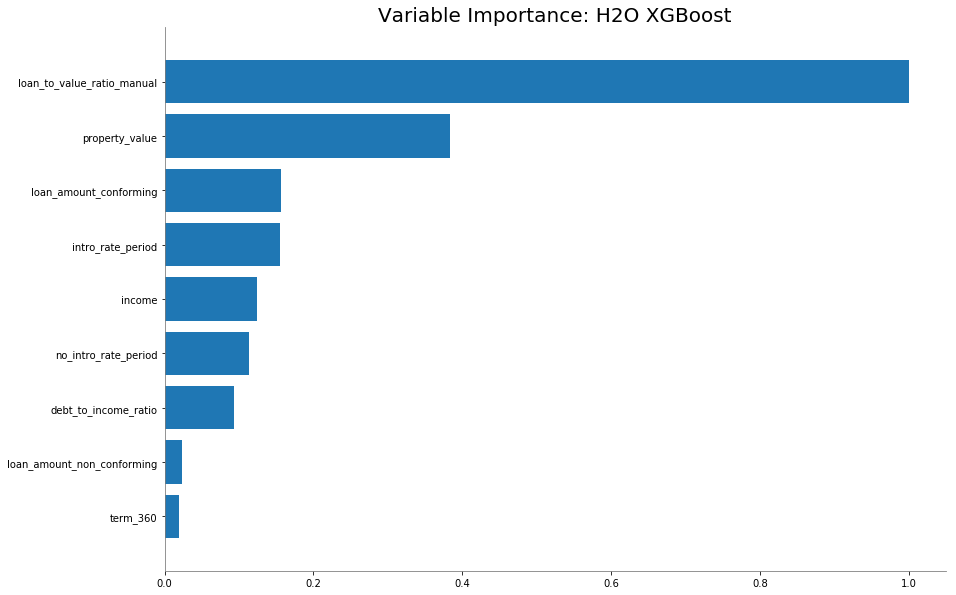

In [53]:
# MXGB var importance
mxgb_default.varimp_plot()

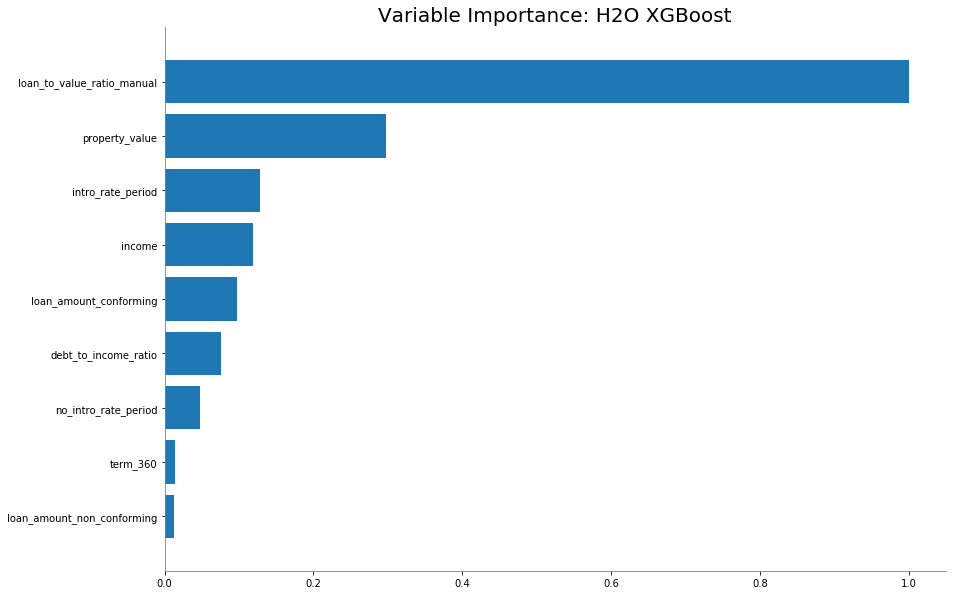

In [54]:
# XGB var importance
xgb_default.varimp_plot()

## Shapey for MXGB

In [55]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.00930465,-0.0123813,0.248827,-0.321049,0.0659561,0.0163076,0,0.0129329,0.00285923,0.693192,-2.34124
-0.0131692,-0.011003,-0.283313,-0.0778434,-0.148493,0.0213461,0,-0.119896,0.00339233,0.208437,-2.34124
-0.0561851,-0.746734,0.505229,0.143106,0.0978285,-0.00605887,0,0.249357,0.0315126,0.419315,-2.34124
-0.0786271,-0.0171469,-0.448513,-0.0246801,-0.105672,0.0176538,0,-0.254953,0.00409433,-2.26628,-2.34124
-0.00751913,-0.00516843,0.280881,-0.0913537,0.15152,0.0166507,0,0.0433297,0.00419523,0.770202,-2.34124


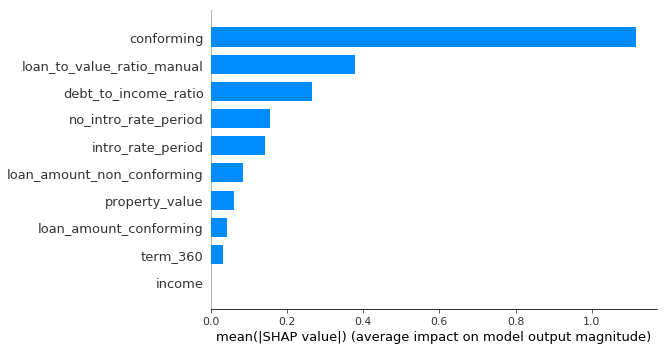

In [56]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [57]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0184798,0.00166175,0.176902,-0.377743,0.0289731,0.0100238,0,0.109529,0.00307945,0.70184,-2.35977
-0.0220951,-0.00329182,-0.436832,-0.137403,-0.248642,0.0178275,0,-0.0243018,0.00293616,0.0887115,-2.35977
-0.76952,-0.695166,0.338486,-0.0432226,-0.150952,-0.000129292,0,0.0383829,0.00316587,0.316657,-2.35977
-0.256807,-0.0727495,-0.550056,-0.03221,-0.0978173,0.0229899,0,-0.119316,0.000746431,-1.95416,-2.35977
-0.0149527,0.0046197,0.230619,-0.0409016,0.168949,0.0112075,0,0.162426,0.00238691,0.758225,-2.35977


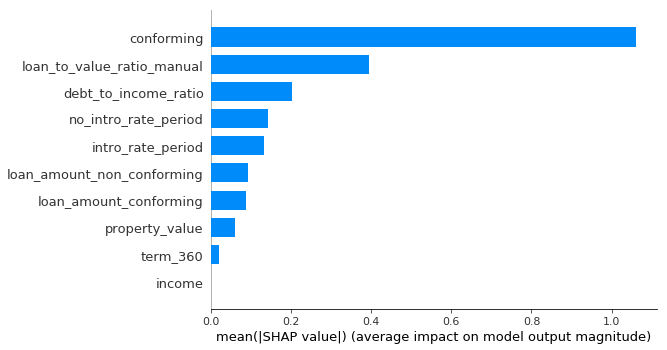

In [58]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

In [55]:
# GBM hyperparameters
hyper_params = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

# MGBM Grid Search (Constrained)

In [56]:
# Train and validate a random grid of GBMs
mgbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mgbm_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mgbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [57]:
# Get the grid results, sorted by validation AUC
mgbm_gridperf2 = mgbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [58]:
print(mgbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0      0.7000000000000001       0.09        10                 0.5   
1                     0.8       0.09        10  0.7000000000000001   
2                     1.0       0.09         5                 0.5   
3                     1.0       0.09        10                 0.9   
4                     0.5        0.1         8  0.7000000000000001   
5      0.7000000000000001       0.08         9  0.6000000000000001   
6                     0.9       0.08         6                 0.8   
7      0.7000000000000001        0.1         3  0.7000000000000001   
8     0.30000000000000004        0.1         6  0.7000000000000001   
9                     0.4       0.08         5                 0.8   
10                    0.9       0.06         6                 0.9   
11                    0.2       0.09         6                 1.0   
12                    0.4       0.07         5                 0.5   
13    0.300000000000

In [59]:
# Grab the top GBM model, chosen by validation AUC
best_mgbm2 = mgbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mgbm_perf2 = best_mgbm2.model_performance(test)

best_mgbm_perf2.auc()

0.7918035006878091

In [60]:
shap_values_mgbm, expected_value_mgbm = get_shapley(best_mgbm2, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0042599,0.000215987,0.401117,-0.0835412,0.127418,0.00425686,0.00126001,0.0814385,-0.0098231,0.805714,-2.56216
-0.0240478,-0.0159796,-0.0735205,-0.00214258,-0.106961,0.00148614,0.00109746,-0.0826819,-0.00839254,0.371125,-2.56216
-0.148951,-0.807302,0.542405,-0.0283994,-0.0268344,-0.0247535,0.00486891,0.239247,-0.00621557,0.443392,-2.56216
-0.0383448,-0.079168,-0.413724,0.00114706,-0.119168,-0.0377027,0.00264979,-0.151721,-0.0332051,-1.268,-2.56216
0.00141676,0.00260304,0.45283,-0.0576242,0.121075,0.003438,0.000955794,0.15371,-0.010487,0.803426,-2.56216


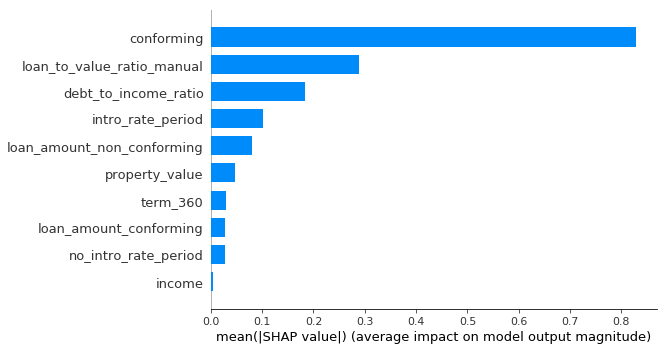

In [61]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

In [62]:
# Save the model
model_path = h2o.save_model(model=best_mgbm2, path="../models/MGBM_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/MGBM_BEST_GRID_v2_HMDA_1575572211.186629/mgbm_grid2_model_36


# GBM Grid Search (Unconstrained)

In [63]:
# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='gbm_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
gbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [64]:
# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [65]:
print(gbm_gridperf2)

           col_sample_rate learn_rate max_depth         sample_rate  \
0                      0.5        0.1         8  0.7000000000000001   
1       0.7000000000000001       0.04         8                 1.0   
2                      0.9       0.08         6                 0.8   
3                      0.4       0.04         9                 0.5   
4       0.7000000000000001       0.08         9  0.6000000000000001   
5       0.6000000000000001       0.04         7                 0.8   
6      0.30000000000000004       0.04        10                 0.9   
7                      0.8       0.05        10  0.6000000000000001   
8                      0.9       0.04         7                 1.0   
9                      0.9       0.06         6                 0.9   
10                     1.0       0.09         5                 0.5   
11                     1.0       0.09        10                 0.9   
12                     0.8       0.09        10  0.7000000000000001   
13    

In [66]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.8115203515185336

In [67]:
shap_values_gbm, expected_value_gbm = get_shapley(best_gbm2, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0207734,-0.00110998,0.476628,-0.151201,0.118533,0.0161394,-0.00352561,0.0681739,0.038041,0.895284,-2.80386
-0.0259547,-0.00375268,-0.19697,-0.0240585,-0.178462,0.022039,-0.00734256,-0.0856482,0.0174152,0.382569,-2.80386
-0.299388,-0.520263,0.427381,-0.0103263,0.0689998,-0.00220278,-0.000214496,0.291293,-0.00335285,0.471993,-2.80386
-0.138435,-0.0803227,-0.497069,0.00224466,-0.0726923,0.0293238,-0.0150638,-0.166781,0.00907944,-1.31328,-2.80386
-0.0182173,0.00316749,0.486108,-0.0688869,0.179537,0.021934,0.00301627,0.167273,0.0389353,0.913243,-2.80386


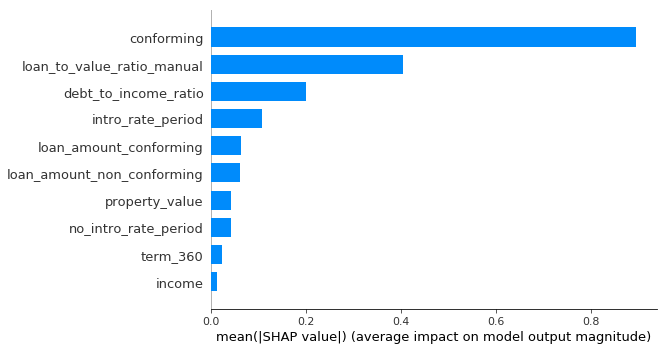

In [68]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

In [69]:
# Save the model
model_path = h2o.save_model(model=best_gbm2, path="../models/GBM_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/GBM_BEST_GRID_v2_HMDA_1575572276.3269708/gbm_grid2_model_56


# Repeat Previous but with XGBoost

In [98]:
# Train and validate a random grid of XGBoost models
mxgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mxgb_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mxgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [99]:
# Get the grid results, sorted by validation AUC
mxgb_gridperf = mxgb_grid.get_grid(sort_by='auc', decreasing=True)

In [100]:
print(mxgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.5        0.1         8  0.7000000000000001   
1      0.7000000000000001       0.08         9  0.6000000000000001   
2                     0.8       0.09        10  0.7000000000000001   
3                     0.9       0.08         6                 0.8   
4                     1.0       0.09        10                 0.9   
5                     1.0       0.09         5                 0.5   
6     0.30000000000000004        0.1         6  0.7000000000000001   
7      0.7000000000000001       0.09        10                 0.5   
8     0.30000000000000004       0.08         6                 0.8   
9                     0.4       0.08         5                 0.8   
10                    0.2       0.09         6                 1.0   
11                    0.8       0.05        10  0.6000000000000001   
12                    0.9       0.06         6                 0.9   
13                  

In [101]:
# Grab the top GBM model, chosen by validation AUC
best_mxgb = mxgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mxgb_perf = best_mxgb.model_performance(test)

best_mxgb_perf.auc()

0.7999949288988425

In [102]:
shap_values_mxgb, expected_value_mxgb = get_shapley(best_mxgb, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0135774,-0.0130416,0.219805,-0.247318,0.0742717,0.0148415,0.00370107,0.0361202,0.00165201,0.602028,-2.30633
-0.0167765,-0.0146054,-0.233851,-0.103313,-0.151232,0.0198723,0.00187643,-0.0968981,0.00337994,0.117832,-2.30633
0.0674466,-1.01512,0.386762,0.106152,0.0871492,-0.0016355,0.0175992,0.335762,0.0217962,0.244159,-2.30633
-0.0623374,-0.0409654,-0.529342,-0.0106386,-0.0773403,0.0185115,0.00161792,-0.200254,0.00273727,-2.11823,-2.30633
-0.0110925,-0.0117077,0.282572,-0.068288,0.167126,0.0155941,0.0043873,0.106964,0.00328848,0.691791,-2.30633


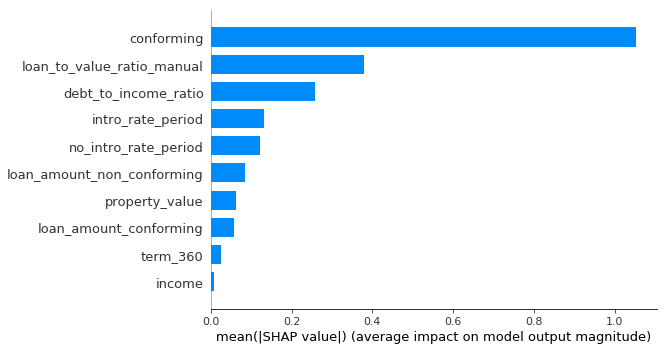

In [103]:
shap.summary_plot(shap_values_mxgb, X, plot_type="bar")

In [104]:
# Save the model
model_path = h2o.save_model(model=best_mxgb, path="../models/MXGB_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/MXGB_BEST_GRID_v2_HMDA_1575574305.369597/mxgb_grid2_model_20


In [105]:
# Train and validate a random grid of XGBoost models
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='xgb_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
xgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [106]:
# Get the grid results, sorted by validation AUC
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)

In [107]:
print(xgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.9       0.08         6                 0.8   
1                     0.5        0.1         8  0.7000000000000001   
2     0.30000000000000004        0.1         6  0.7000000000000001   
3                     1.0       0.09         5                 0.5   
4     0.30000000000000004       0.08         6                 0.8   
5                     0.9       0.06         6                 0.9   
6                     0.4       0.04         9                 0.5   
7     0.30000000000000004       0.04        10                 0.9   
8      0.7000000000000001       0.08         9  0.6000000000000001   
9      0.7000000000000001       0.04         8                 1.0   
10                    0.2       0.09         6                 1.0   
11     0.6000000000000001       0.04         7                 0.8   
12                    0.4       0.08         5                 0.8   
13                  

In [108]:
# Grab the top GBM model, chosen by validation AUC
best_xgb = xgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgb_perf = best_xgb.model_performance(test)

best_xgb_perf.auc()

0.813455372778589

In [109]:
shap_values_xgb, expected_value_xgb = get_shapley(best_xgb, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0147754,-0.00515738,0.294563,-0.252677,0.10337,0.00846682,1.85473e-05,0.0639321,0.00164928,0.629654,-2.31771
-0.0184735,-0.0124497,-0.382517,-0.0638277,-0.216879,0.0141951,1.85473e-05,-0.0830241,0.00198269,0.0856961,-2.31771
-0.463241,-0.66681,0.41308,-0.0233801,-0.0609548,0.00272011,3.75271e-05,0.0486453,-0.000676707,0.398141,-2.31771
-0.191724,-0.143845,-0.605606,-0.061413,-0.104917,0.0150929,1.85473e-05,-0.103392,0.00168147,-1.8645,-2.31771
-0.0126218,0.000644944,0.340064,-0.07133,0.175992,0.00981694,1.85473e-05,0.0871449,0.00146923,0.719132,-2.31771


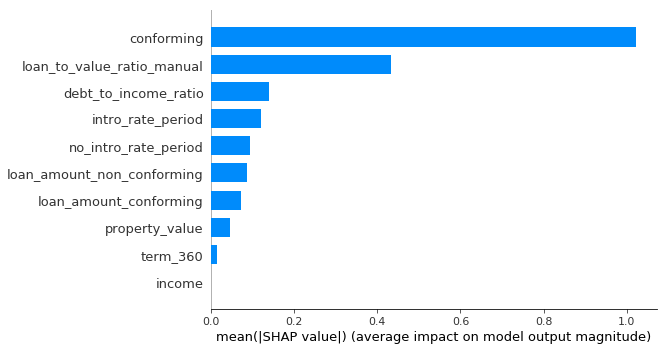

In [110]:
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

In [111]:
# Save the model
model_path = h2o.save_model(model=best_xgb, path="../models/XGB_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/XGB_BEST_GRID_v2_HMDA_1575575935.933395/xgb_grid2_model_11
